##Introduction

This notebook will be used to create and fit models designed to predict whether individuals with certain risk factors will experience heart disease or heart attacks. This can be utilized by medical professionals in efforts to intervene before individuals with high risk actually experience these cardiac events.  A proactive individual with reasonably low risk could use this model to minimize their risk of cardiac events.

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Import Libraries

First, we will need to import the Python Libraries we will use to create and evaluate our models.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


##Load Data

Next, we will load our data.

In [49]:
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo/Raw Data/heart_disease_health_indicators_BRFSS2015.csv')
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [51]:
df.shape

(253680, 22)

##Data Cleaning

We saw in our EDA that the dataset has no null values and every point is properly formatted.

We did find duplicated values, so we will drop them.

In [52]:
# confirm duplicated values
df.duplicated().any()

True

In [53]:
# drop duplicated values
df.drop_duplicates(keep = 'first', inplace = True)

In [54]:
# confirm duplicates are dropped
df.duplicated().any()

False

##Pre-processing

We will begin our pre-processing by declaring our target vector and features matrix.  We will then implement a train_test_split.

In [55]:
# check balance of target
df['HeartDiseaseorAttack'].value_counts(normalize = 'true')

0.0    0.896784
1.0    0.103216
Name: HeartDiseaseorAttack, dtype: float64

In [56]:
# declare features (X) and target (y)
y = df['HeartDiseaseorAttack']
X = df.drop(columns = 'HeartDiseaseorAttack')

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

Our target is very unbalanced.  This can make modeling difficult.

Also, our dataset is large.  This can drastically slow model production.

Both of these issues will be dealt with utilizing random under-sampling.

In [57]:
# import imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

# utilize RandomUnderSampler to build usable training data
rus = RandomUnderSampler(random_state = 42, replacement = True)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [58]:
print('Original Dataset Shape:\n', y_train.value_counts())
print('\nResampled Dataset Shape:\n', y_rus.value_counts())

Original Dataset Shape:
 0.0    154552
1.0     17783
Name: HeartDiseaseorAttack, dtype: int64

Resampled Dataset Shape:
 1.0    17783
0.0    17783
Name: HeartDiseaseorAttack, dtype: int64


We see that our dataset for training has reduced from 172,335 rows to 35,566 rows. Also, our target is now balanced.

We will now utilize this data for model creation.

In [59]:
# instantiate num_selector
num_sel = make_column_selector(dtype_include = ['number'])

# instantiate preprocessor
preprocessor = make_column_transformer((StandardScaler(), num_sel))

##Model Selection

With our pre-processing complete, we will create a function to test default models in an attempt to determine which algorithms will provide the best results.

In [60]:
def evaluate_default(pipe):
  pipe.fit(X_rus, y_rus)

  train_pred = pipe.predict(X_train)
  test_pred = pipe.predict(X_test)

  print('Training Metrics:\n', classification_report(y_train, train_pred))
  print('\nTest Metrics:\n', classification_report(y_test, test_pred))

  cm = confusion_matrix(y_test, test_pred, normalize = 'true')
  sns.heatmap(cm, annot = True, cmap = 'Reds')

Training Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84    154552
         1.0       0.25      0.78      0.38     17783

    accuracy                           0.74    172335
   macro avg       0.61      0.76      0.61    172335
weighted avg       0.89      0.74      0.79    172335


Test Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     51512
         1.0       0.26      0.78      0.39      5934

    accuracy                           0.74     57446
   macro avg       0.61      0.76      0.61     57446
weighted avg       0.89      0.74      0.79     57446



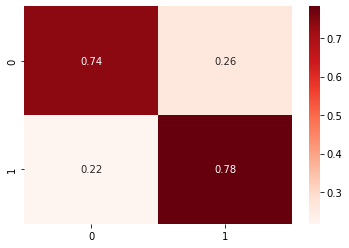

In [61]:
# test Logistic Regression
log_pipe = make_pipeline(preprocessor, LogisticRegression(random_state = 42))

evaluate_default(log_pipe)

Our default Logistic Regression achieved the best test recall score among the algorithms we tested.  This is important for our specific data because we want to avoid incorrectly telling people that they will not experience heart disease. Given Logistic Regression's performance in recall, we will tune it for optimal results to consider for our final model.

Training Metrics:
               precision    recall  f1-score   support

         0.0       1.00      0.73      0.85    154552
         1.0       0.30      1.00      0.46     17783

    accuracy                           0.76    172335
   macro avg       0.65      0.87      0.65    172335
weighted avg       0.93      0.76      0.81    172335


Test Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.71      0.82     51512
         1.0       0.24      0.79      0.37      5934

    accuracy                           0.72     57446
   macro avg       0.60      0.75      0.59     57446
weighted avg       0.89      0.72      0.77     57446



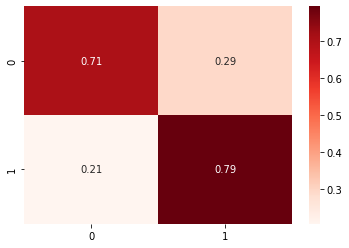

In [62]:
# test Random Forest
rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(random_state = 42))

evaluate_default(rf_pipe)

Training Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.70      0.82    154552
         1.0       0.24      0.83      0.37     17783

    accuracy                           0.72    172335
   macro avg       0.61      0.76      0.60    172335
weighted avg       0.90      0.72      0.77    172335


Test Metrics:
               precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     51512
         1.0       0.22      0.75      0.34      5934

    accuracy                           0.70     57446
   macro avg       0.59      0.72      0.57     57446
weighted avg       0.88      0.70      0.76     57446



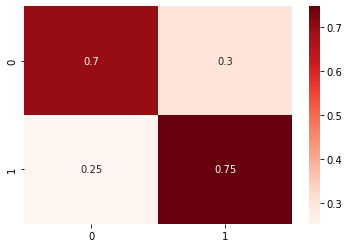

In [63]:
# test KNN
knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())

evaluate_default(knn_pipe)

Both Random Forest and KNN were outperformed by the default Logistic Regression, as well as all 3 Boosted Models that were tested.  As such, neither will be tuned for consideration for our model.

Training Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.72      0.83    154552
         1.0       0.25      0.81      0.38     17783

    accuracy                           0.73    172335
   macro avg       0.61      0.76      0.60    172335
weighted avg       0.90      0.73      0.78    172335


Test Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     51512
         1.0       0.25      0.81      0.38      5934

    accuracy                           0.73     57446
   macro avg       0.61      0.76      0.60     57446
weighted avg       0.90      0.73      0.78     57446



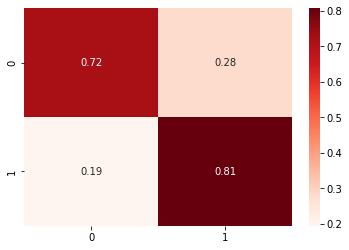

In [64]:
# test GBC
gbc_pipe = make_pipeline(preprocessor, GradientBoostingClassifier(random_state = 42))

evaluate_default(gbc_pipe)

Training Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.72      0.83    154552
         1.0       0.25      0.82      0.38     17783

    accuracy                           0.73    172335
   macro avg       0.61      0.77      0.60    172335
weighted avg       0.90      0.73      0.78    172335


Test Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     51512
         1.0       0.25      0.81      0.38      5934

    accuracy                           0.73     57446
   macro avg       0.61      0.76      0.60     57446
weighted avg       0.90      0.73      0.78     57446



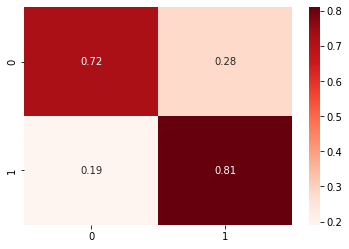

In [65]:
# test Light GBM
lgbm_pipe = make_pipeline(preprocessor, LGBMClassifier(random_state = 42))

evaluate_default(lgbm_pipe)

Training Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.72      0.83    154552
         1.0       0.25      0.81      0.38     17783

    accuracy                           0.73    172335
   macro avg       0.61      0.76      0.60    172335
weighted avg       0.90      0.73      0.78    172335


Test Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     51512
         1.0       0.25      0.81      0.38      5934

    accuracy                           0.73     57446
   macro avg       0.61      0.76      0.60     57446
weighted avg       0.90      0.73      0.78     57446



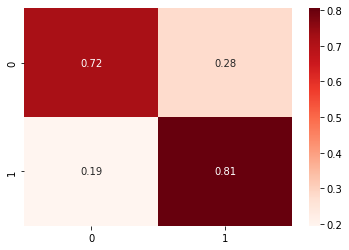

In [66]:
# test XGBOOST
xgb_pipe = make_pipeline(preprocessor, XGBClassifier(random_state = 42))

evaluate_default(xgb_pipe)

All boosted models (GradientBoostingClassifier, Light GBM, and XGBOOST) performed equally in the default testing.  These were our most accurate default models.  We will tune XGBOOST for consideration for our final model.

##Tuning Candidates for Final Model Consideration

We will utilize GridSearchCV to optimize Logistic Regression and XGBOOST models before testing to determine final model for implementation.

##Logistic Regression Hyperparameter Tuning

In [21]:
# setting parameters for grid search
log_params = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'logisticregression__C': [.001, .01, .1, 1, 10, 100, 1000],
              'logisticregression__random_state': [42]}

In [22]:
# utilize GridSearchCV to optimize LogisticRegression
log_grid = GridSearchCV(log_pipe, log_params)
log_grid.fit(X_rus, y_rus)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f222f596690>)])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                   1000],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet', 'none'],
                         'logisticregression__random_state': [42],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                    

In [23]:
# get optimal hyperparameters for Logistic Regression
log_grid.best_params_

{'logisticregression__C': 1,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': 42,
 'logisticregression__solver': 'sag'}

In [24]:
# set optimized Logistic Regression
best_log = log_grid.best_estimator_

##XGBOOST Hyperparameter Tuning

This GridSearch seems to be taking excessively long to run.  3 attempts at an hour each. Final edits will be done when this is completed.

"Sometimes it's not done, but it's due." - Josh

In [31]:
# set parameters for gridsearch
xgb_params = {'xgbclassifier__booster': ['gbtree', 'gblinear', 'dart'],
              'xgbclassifier__max_depth': [1, 3, 6, 10]}

In [32]:
xgb_grid = GridSearchCV(xgb_pipe, xgb_params)
xgb_grid.fit(X_rus, y_rus)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f222f596690>)])),
                                       ('xgbclassifier',
                                        XGBClassifier(random_state=42))]),
             param_grid={'xgbclassifier__booster': ['gbtree', 'gblinear',
                                                    'dart'],
                         'xgbclassifier__max_depth': [1, 3, 6, 10]})

In [33]:
# view optimal GBC hyperparameters
xgb_grid.best_params_

{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__max_depth': 3}

In [34]:
# set optimized GradientBoosting Classifier
best_xgb = xgb_grid.best_estimator_

##Test Tuned Models

Training Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84    154552
         1.0       0.25      0.78      0.38     17783

    accuracy                           0.74    172335
   macro avg       0.61      0.76      0.61    172335
weighted avg       0.89      0.74      0.79    172335


Test Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     51512
         1.0       0.26      0.78      0.39      5934

    accuracy                           0.74     57446
   macro avg       0.61      0.76      0.61     57446
weighted avg       0.89      0.74      0.79     57446



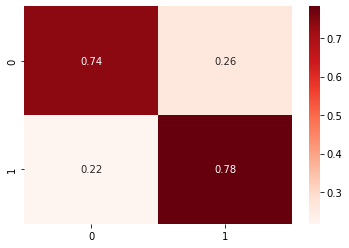

In [67]:
#evaluate optimized logistic regression
evaluate_default(best_log)

Our Logistic Regression, when trained using our under-sampled data, performed fairly well. 78% of the individuals it predicts to have heart disease or attack actually do.  However, 22% of the individuals it predicts not to have heart disease or attack end up having one. 

While 26% of the individuals it predicts to have heart disease or attack end up not having cardiac disease, in a real world application, there is no harm from telling a patient that they are trending towards heart disease or attack when they are not.  The patient may change some habits that are accepted as unhealthy to try to prevent it, but this is still a positive effect.

Training Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.72      0.83    154552
         1.0       0.25      0.81      0.38     17783

    accuracy                           0.73    172335
   macro avg       0.61      0.76      0.60    172335
weighted avg       0.90      0.73      0.78    172335


Test Metrics:
               precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     51512
         1.0       0.25      0.81      0.38      5934

    accuracy                           0.73     57446
   macro avg       0.61      0.76      0.60     57446
weighted avg       0.90      0.73      0.78     57446



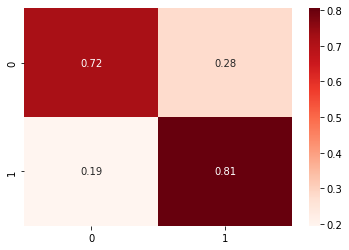

In [68]:
# evaluate XGBOOST
evaluate_default(best_xgb)

Our XGBOOST model, when trained on our undersampled data, performed the strongest among all models tested.  81% of the individuals it predicts to have heart disease or attack actually have suffered from cardiac disease.  

19% of the individuals our model predicts to not suffer from heart disease or attack, actually have suffered from cardiac disease.  This model is not intended to be used for diagnostics.  This model would be used for early detection of at-risk individuals for intervention purposes. For this reason, 19% false negative is acceptable given the sheer volume of individuals that will never experience heart disease or attack.

28% of the individuals our model predicts to suffer from heart disease or attack actually have not.  In our targeted application, this is a no-harm prediction.  These individuals may make lifestyle changes to minimize their risk of experiencing cardiac events, but these changes are accepted as beneficial from a medical perspective.

Because our XGBOOST model trained on our undersampled data outperforms others in accurately predicting heart disease or attack, and minimizing false negative predictions, this will be the model moving forward to production.

Training Metrics:
               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95    154552
         1.0       0.54      0.12      0.20     17783

    accuracy                           0.90    172335
   macro avg       0.72      0.56      0.57    172335
weighted avg       0.87      0.90      0.87    172335


Test Metrics:
               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     51512
         1.0       0.57      0.12      0.20      5934

    accuracy                           0.90     57446
   macro avg       0.74      0.56      0.57     57446
weighted avg       0.87      0.90      0.87     57446



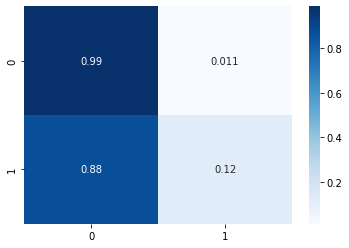

In [41]:
#test logistic regression using entire dataset
full_log = best_log.fit(X_train, y_train)

log_train = full_log.predict(X_train)
log_test = full_log.predict(X_test)

print('Training Metrics:\n', classification_report(y_train, log_train))
print('\nTest Metrics:\n', classification_report(y_test, log_test))

log_cm = confusion_matrix(y_test, log_test, normalize = 'true')
sns.heatmap(log_cm, annot = True, cmap = 'Blues');

Training Metrics:
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.95    154552
         1.0       0.58      0.09      0.16     17783

    accuracy                           0.90    172335
   macro avg       0.74      0.54      0.55    172335
weighted avg       0.87      0.90      0.87    172335


Test Metrics:
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.95     51512
         1.0       0.61      0.09      0.16      5934

    accuracy                           0.90     57446
   macro avg       0.76      0.54      0.55     57446
weighted avg       0.87      0.90      0.87     57446



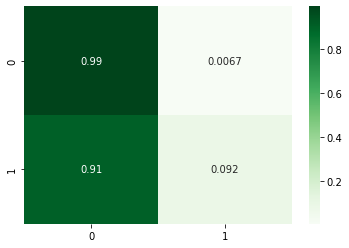

In [43]:
# test XGBOOST using entire dataset
full_xgb = best_xgb.fit(X_train, y_train)

xgb_train = full_xgb.predict(X_train)
xgb_test = full_xgb.predict(X_test)

print('Training Metrics:\n', classification_report(y_train, xgb_train))
print('\nTest Metrics:\n', classification_report(y_test, xgb_test))

xgb_cm = confusion_matrix(y_test, xgb_test, normalize = 'true')
sns.heatmap(xgb_cm, annot = True, cmap = 'Greens');

When both models are trained using the full dataset, our accuracy skyrockets.  However, both our Logistic Regression model and our XGBOOST model perform poorly predicting the positive class. 88% and 91% false negative predictions.  These results make both models unusable in a real world setting.

##Final Production Model

The model moving forward to production will be our Optimized XGBOOST (best_xgb) trained on our undersampled data.